# Comparing execution times: `SurrealML` vs `ONNX` vs `PyTorch` 

## Table of contents

1.  <a href="#1">General dependencies and helpers</a>
2.  <a href="#2">Some words about SurrealML</a>
3.  <a href="#3">Problem refinement</a>
4.  <a href="#4">A typical neural network</a>
5.  <a href="#5">Loading the model to SurrealDB</a>
6.  <a href="#6">Generating and inserting fake data to SurrealDB</a>

<h2 id="1"></h2>

## General dependencies and helpers

We will start by exporting some tools we will use for timing, and operating with SurrealDB/SurrrealML...

In [1]:
import os
import subprocess
import time
from functools import wraps

import torch
import torch.nn as nn

from surrealml import SurMlFile, Engine
from surrealist import Surreal
from helpers import remove_container_if_exists
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.magic import register_cell_magic


def chronometer(foo):
    @wraps(foo)
    def wrapper(*args, **kwargs):
        start = time.time()
        _ = foo(*args, **kwargs)
        end = time.time()
        return end - start

    return wrapper


@register_cell_magic
def skip(line, cell):
    return

<h2 id="2"></h2>

## Some words about SurrealML

According to the [official docs](https://surrealdb.com/docs/surrealml):
    
```text
SurrealML is an engine that seeks to do one thing, and one thing well: store and execute trained ML models. SurrealML does not intrude on the training frameworks that are already out there, instead works with them to ease the storage, loading, and execution of models. Someone using SurrealML will be able to train their model in a chosen framework in Python, save their model, and load and execute the model in either Python or Rust.
```

Basically, we aim to develop and train models using `PyTorch/scikit-learn/Tensorflow/linfa`, and then load them to SurrealDB.

Inside SurrealDB, a model is represented in the [.surml format](https://surrealdb.com/docs/surrealml/storage#the-anatomy-of-a-surml-file). Schematically, from top to bottom of a .surml file, we roughly have that:

`.surml file` =  `4 byte integer` + `variable metadata [size specified by 4 bytes integer]` + `model parameters [ONNX format]`

A .surml file is loaded by starting with the 4 bytes integer, and then using it to determine the length of the model metadata. Once the model metadata has been loaded, the loader assumes that the rest is ONNX protobuf, and parses it accordingly.

At the time of writing, in the [source code](https://github.com/surrealdb/surrealml/blob/main/surrealml/engine/__init__.py) of the `Engine` enum, we have the following docstring:

_Attributes_:
- **PYTORCH**: The PyTorch engine which will be PyTorch and ONNX.
- **NATIVE**: The native engine which will be native Rust and Linfa.
- **SKLEARN**: The scikit-learn engine which will be scikit-learn and ONNX.
- **TENSORFLOW**: The TensorFlow engine which will be TensorFlow and ONNX.
- **ONNX**: The ONNX engine which bypasses the conversion to ONNX.

Thus, we may infer that, for the sake of comparing `SurrealML` vs `ONNX` vs `PyTorch`, for the same model, it should be equivalent using `Engine.PYTORCH`/`Engine.SKLEARN`/`Engine.TENSORFLOW`, as irrespective of the framework used, the model will be exported to the ONNX first.

<a id="3"></a>

## Problem refinement

We single out three cases that may be encountered in practice, namely:

1. **Execute with SurrealML[inside SurrealDB] && fetch data from SurrealDB [optional]**: predicting with the model in .surml format _inside_ the SurrealDB, and then _optionally_ fetching the prediction from SurrealDB.
2. **Fetch data from SurrealDB && execute with PyTorch**: fetching the data from SurrealDB and _externally_ predicting with the PyTorch model.
3. **Fetch data from SurrealDB && execute with ONNX runtime**: fetching the data from SurrealDB and _externally_ predicting with the ONNX model.

Given the 3 scenarios above, one may deduct the following benefits of using SurrealML:

- **Reduced Database Transactions**
  - No need to fetch data from SurrealDB if predictions are not consumed immediately.
  - Eliminates at least **2 database transactions**, if fetching the input data and inserting the computed predictions is not needed anymore.

- **Improved Security**
  - Operates on the input used for predictions, as well as on the calculated predictions, without needing to retrieve it from the database, enhancing security.


However, one may be curious about the `performance` of SurrealML, so we will provide an implementation of an experiment to measure just this.

<h2 id="4"></h2>

## A toy neural network

In the following, we define `ToyNet`, which is a two-layer feedforward neural network with ReLU activation. It consists of an input layer with 10 features, a hidden layer of 5 neurons (`fc1`), and an output layer of 1 neuron (`fc2`).

In [2]:
class ToyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def __str__(self) -> str:
        return self.__class__.__name__

... and then we instantiate the model, and load a persistent version of the randomly intialized parameters of the model, from a previous run: 

In [ ]:
model = ToyNet()
# torch.save(model.state_dict(), "./params.pth")
model.load_state_dict(torch.load("params.pth"))

<All keys matched successfully>

<h2 id="5"></h2>

## Starting a SurrealDB instance

It is high time to start a SurrealDB instance, ready to be accessed at port `8000` of `localhost`. Moreover, as SurrealDB organizes the data in a two-tier way, we have to specify a namespace, let´s name it `comparison_test`, as well as a database, for which we choose `surrealml_vs_onnx_vs_pytorch`.

In [4]:
URL = "http://0.0.0.0:8000"
NS = "comparison_test"
DB = "surrealml_vs_onnx_vs_pytorch"

__NOTE__: From here on, those who wish to follow should have `Docker Engine` installed. We also mention that this notebook is compatible with __v.1.5.4-1.5.5__ of SurrealDB. 

For convenience, we apriori eliminate any existing container named `surrealdb` using the helper function `remove_container_if_exists`:

In [ ]:
local_model_directory = os.getcwd()
model_file = "model.surml"
container_name = "surrealdb"

remove_container_if_exists(container_name)

No existing container named 'surrealdb' found or could not be removed.


Error response from daemon: No such container: surrealdb


Our path is clear now, so we may use the command from the [Run with Docker](https://surrealdb.com/docs/surrealdb/installation/running/docker) of the SurrealDB docs. For convenience, we may start the database in memory, however please mind that you will need to have at least of 2.7 GB of extra memory to perform the performance test below...

In [6]:
current_directory = os.getcwd()
mount_directory = os.path.join(current_directory, "mnt")

docker_run_command = [
    "docker",
    "run",
    "--name",
    "surrealdb",
    "--rm",
    "--pull",
    "always",
    "-p",
    "8000:8000",
    "--user",
    "root",
    "-v",
    f"{mount_directory}:/data_app",
    "surrealdb/surrealdb:v1.5.5",
    "start",
    "file:/data_app/mydatabase.db",
]

container_process = subprocess.Popen(docker_run_command)
time.sleep(4)

v1.5.5: Pulling from surrealdb/surrealdb
Digest: sha256:b52fcd0b7ce8802fe376e220508a2cbcc082c4f9443e81775f7111437273d4ad
Status: Image is up to date for surrealdb/surrealdb:v1.5.5



 .d8888b.                                             888 8888888b.  888888b.
d88P  Y88b                                            888 888  'Y88b 888  '88b
Y88b.                                                 888 888    888 888  .88P
 'Y888b.   888  888 888d888 888d888  .d88b.   8888b.  888 888    888 8888888K.
    'Y88b. 888  888 888P'   888P'   d8P  Y8b     '88b 888 888    888 888  'Y88b
      '888 888  888 888     888     88888888 .d888888 888 888    888 888    888
Y88b  d88P Y88b 888 888     888     Y8b.     888  888 888 888  .d88P 888   d88P
 'Y8888P'   'Y88888 888     888      'Y8888  'Y888888 888 8888888P'  8888888P'




2024-10-17T00:07:09.138353Z  INFO surreal::env: Running 1.5.5 for linux on x86_64
2024-10-17T00:07:09.138369Z  WARN surreal::dbs: ❌🔒 IMPORTANT: Authentication is disabled. This is not recommended for production use. 🔒❌
2024-10-17T00:07:09.138375Z  INFO surrealdb_core::kvs::ds: Starting kvs store at file:///data_app/mydatabase.db
2024-10-17T00:07:09.203791Z  INFO surrealdb_core::kvs::ds: Started kvs store at file:///data_app/mydatabase.db
2024-10-17T00:07:09.204380Z  INFO surrealdb::net: Started web server on 0.0.0.0:8000


<h2 id="6"></h2>

## Loading the model to SurrealDB

As we know from the Engine docstring, under the hood SurrealML converts any PyTorch/scikit-learn/Tensorflow model to the ONNX format, hence we switch the model to inference mode:

In [7]:
model.eval()

ToyNet(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

The `SurMlFile` object comes in handy to save our model in the `.surml` format. As our model was developed using PyTorch, we select the `Engine.PYTORCH` option:

In [8]:
# Owing to the fact that the SURML format builds on the ONNX format, we have to specify an example input
example_input = torch.rand(1, 10)
surml_file = SurMlFile(
    model=model, name=str(model), inputs=example_input, engine=Engine.PYTORCH
)

# we also choose a local path where to save the model, as well as a version of the model
path_surml = "./model.surml"
surml_file.add_version("0.0.1")
surml_file.save(path_surml)

/home/vld28/Desktop/dev/article/surrealml-vs-onnx-vs-pytorch/surrealml-vs-onnx-vs-pytorch/.venv/lib/python3.11/site-packages/torch/onnx/utils.py:847: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x7ff4ec20dfb0>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")


Subsequently, we will use the SurrealDB CLI programatically to upload the model to SurrealDB:

In [9]:
# now we use the surreal ml command inside the containerized SurrealDb, to import the model file .surml from the mounted volume
try:
    command_inside_container = [
        "docker",
        "exec",
        container_name,
        "/surreal",
        "ml",
        "import",
        "--endpoint",
        "http://0.0.0.0:8000",
        "--ns",
        "comparison_test",
        "--db",
        "surrealml_vs_onnx_vs_pytorch",
        "/data_app/" + model_file,
    ]
    output = subprocess.check_output(command_inside_container, stderr=subprocess.STDOUT)
    print(output.decode("utf-8"))
except subprocess.CalledProcessError as e:
    print(f"Command '{e.cmd}' failed with return code {e.returncode}.")
    print("Output:\n", e.output.decode("utf-8"))

2024-10-17T00:07:11.758410Z  INFO surreal::cli::ml::import: The SurrealML file was imported successfully



According to the last logs, that resulted from executing the `surreal ml` command inside the `surrealdb` Docker container, the .surml file should be in SurrealDB. By using the [surreal sql](https://surrealdb.com/docs/surrealdb/cli/sql#sql-command) command inside the `surrealdb` container as well, I can see that the model was correctly uploaded to SurrealDB:

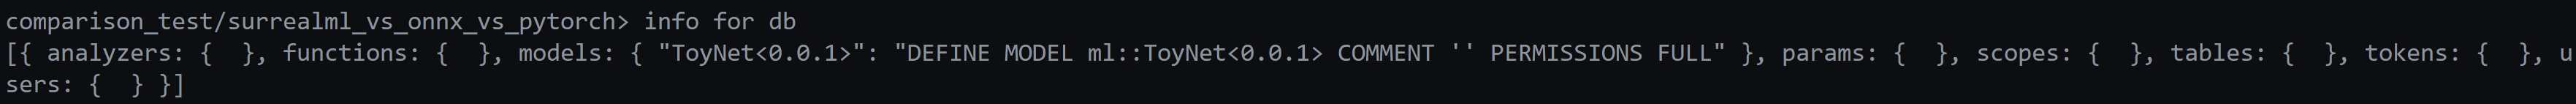

According to the documentation, the instance of the SurMlFile has an equivalent `.upload()` method, however I could not figure out what I did wrongly...

In [10]:
%%skip
"""
###################################################################################################
--> The other way to upload a model to SurrealDB. Could not make it work by the time of writing :( 
###################################################################################################
"""
surml_file.upload(
    path="./model.surml",
    url=URL,
    chunk_size=36864,
    namespace=NS,
    database=DB,
    username=USR,
    password=PASS)


<h2 id="6"></h2>

## Generating and inserting fake data to SurrealDB

We connect to SurrealDB and insert randomly generated test data in batches defined by max_test_size = $2^{26}$ datapoints, split into chunks of chunk_size = $2^{16}$.

 Knowing that a datapoint is effectively a random float value, some back-of-the-envelope calculations (assuming that we operate on single precision) lead us to 4 bytes per float * 10 floats (the size of the input of our model) * $2^{24}$ ≈ `1.25 GB`. In case your machine supports less than this, or, on the contrary, you want to do more extensive benchmarking, adjust the values below accordingly.

In [11]:
max_test_size = 2**16#adjust based on disk size
chunk_size = 2**10 #adjust this according to RAM size
number_chunks = max_test_size // chunk_size

URL = "http://localhost:8000"
NS = "comparison_test"
DB = "surrealml_vs_onnx_vs_pytorch"

surreal = Surreal(
    url=URL,
    namespace=NS,
    database=DB,
    timeout=10**8,
)

Let us create the fake inputs of size 10 datapoints, coming in batches of $2^{16}$ inputs...

In [12]:
%%skip
with surreal.connect() as connect:
    for _ in range(number_chunks):
        test_inputs = torch.rand(chunk_size, 10).tolist()
        query = f"CREATE inputs:ulid() SET value = {test_inputs};"
        result = connect.query(query)

        if result.status == 'OK':
            continue
        else:
            print(f"Failed to insert: {input}, Result: {result}")

In [13]:
@chronometer
def evaluate_with_surrealdb(test_size, connect):
    _ = connect.query(
        f"SELECT VALUE ml::ToyNet<0.0.1>(value) FROM inputs LIMIT {test_size};"
    ).result

In [14]:
surreal_times = {}
test_step = 2**3
number_steps = number_chunks // test_step

try:
    with surreal.connect() as connect:
        for increment in range(number_steps):
            test_size = (increment + 1) * test_step
            elapsed_time = evaluate_with_surrealdb(test_size, connect)
            print(
                f"For {test_size} collections of 10 by {chunk_size} datapoints, it took {elapsed_time} seconds"
            )
            surreal_times[test_size] = elapsed_time
except Exception as e:
    print(e)

For 8 collections of 10 by 1024 datapoints, it took 0.0015554428100585938 seconds
For 16 collections of 10 by 1024 datapoints, it took 0.0012001991271972656 seconds
For 24 collections of 10 by 1024 datapoints, it took 0.0014061927795410156 seconds
For 32 collections of 10 by 1024 datapoints, it took 0.0011794567108154297 seconds
For 40 collections of 10 by 1024 datapoints, it took 0.001331329345703125 seconds
For 48 collections of 10 by 1024 datapoints, it took 0.0012929439544677734 seconds
For 56 collections of 10 by 1024 datapoints, it took 0.0012559890747070312 seconds
For 64 collections of 10 by 1024 datapoints, it took 0.0011591911315917969 seconds


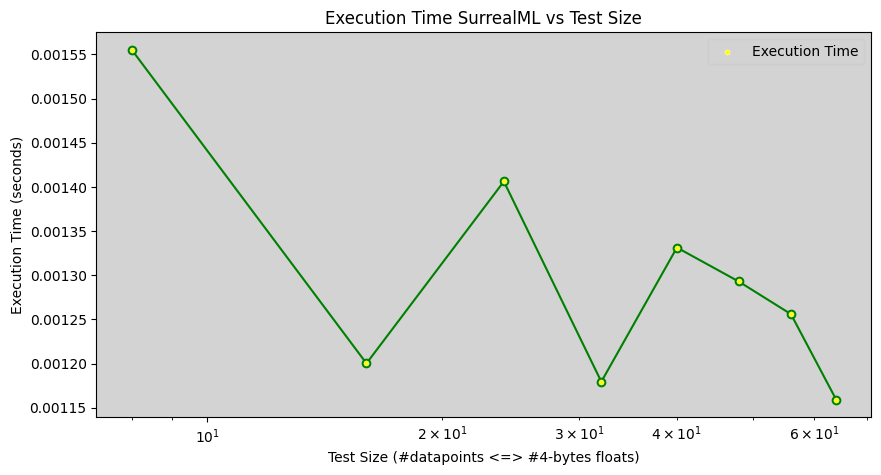

In [15]:
plt.rcParams["axes.facecolor"] = "#D3D3D3"
os.makedirs("./plots", exist_ok=True)

test_sizes = list(surreal_times.keys())
execution_times = list(surreal_times.values())

plt.figure(figsize=(10, 5))

plt.plot(test_sizes, execution_times, marker="o", color="green")
sns.scatterplot(
    x=test_sizes,
    y=execution_times,
    s=14,
    color="yellow",
    label="Execution Time",
    zorder=2,
)

plt.xlabel("Test Size (#datapoints <=> #4-bytes floats)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time SurrealML vs Test Size")
plt.xscale("log")
# plt.yscale('log')
plt.legend()
plot_path = os.path.join(os.getcwd(), "plots", "execution_time_vs_test_size.png")
plt.savefig(plot_path)
plt.show()

In [16]:
@chronometer
def evaluate_pytorch(test_size, connect):
    inputs = connect.query(
        f"SELECT VALUE value FROM inputs LIMIT {test_size}"
    ).to_dict()["result"]

    with torch.no_grad():
        _ = model.forward(torch.tensor(inputs))

In [17]:
pytorch_times = {}
try:
    with surreal.connect() as connect:
        for increment in range(number_steps):
            test_size = (increment + 1) * test_step

            elapsed_time = evaluate_pytorch(test_size, connect)
            print(
                f"For {test_size} collections of 10 by {chunk_size} datapoints, it took {elapsed_time} seconds"
            )
            pytorch_times[test_size] = elapsed_time
except Exception as e:
    print(e)

For 8 collections of 10 by 1024 datapoints, it took 0.0078051090240478516 seconds
For 16 collections of 10 by 1024 datapoints, it took 0.013068675994873047 seconds
For 24 collections of 10 by 1024 datapoints, it took 0.018052101135253906 seconds
For 32 collections of 10 by 1024 datapoints, it took 0.02255988121032715 seconds
For 40 collections of 10 by 1024 datapoints, it took 0.02788376808166504 seconds
For 48 collections of 10 by 1024 datapoints, it took 0.03600597381591797 seconds
For 56 collections of 10 by 1024 datapoints, it took 0.043359994888305664 seconds
For 64 collections of 10 by 1024 datapoints, it took 0.04852437973022461 seconds


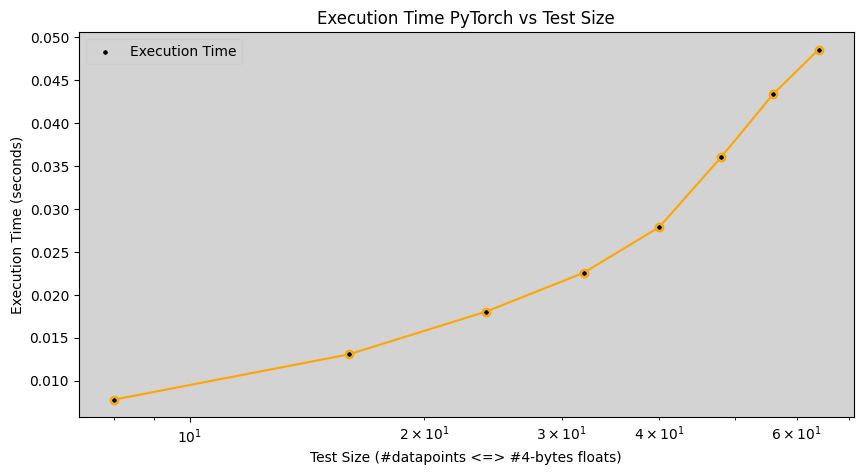

In [19]:
test_sizes = list(pytorch_times.keys())
execution_times = list(pytorch_times.values())

plt.figure(figsize=(10, 5))

plt.plot(test_sizes, execution_times, marker="o", color="orange")
sns.scatterplot(
    x=test_sizes,
    y=execution_times,
    s=14,
    color="black",
    label="Execution Time",
    zorder=2,
)

plt.xlabel("Test Size (#datapoints <=> #4-bytes floats)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time PyTorch vs Test Size")
plt.xscale("log")
# plt.yscale('log')
plt.legend()
plot_path = os.path.join(os.getcwd(), "plots", "execution_time_vs_test_size.png")
plt.savefig(plot_path)
plt.show()